In [1]:
import pandas as pd 
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
import numpy as np
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list, linkage 
from matplotlib import pyplot as plt
import re
import seaborn as sbn
import math
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"

# make dataframe

In [2]:
df=pd.read_csv('all_annotated.csv')
df['median'] = df.median(numeric_only=True, axis=1)

# get rid of all with median of zeros 

In [3]:
df_nonzero=df.query('median != 0')
del df_nonzero['t_name']
df_nonzero

,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D,median
3,CR40182,23.712564,11.967821,20.767498,13.566818,18.802116,26.802691,22.819895,11.682728,21.894249,13.922059,16.482141,12.622680,31.800016,22.883186,14.330216,17.202570,18.002343
8,Parp,10.997173,0.000000,0.000000,0.000000,14.805335,0.000000,17.601667,10.729349,0.000000,0.000000,14.888651,14.518989,20.343670,4.087385,0.000000,25.284622,7.408367
9,Alg-2,19.067924,0.000000,14.832370,27.793905,22.290230,7.846396,13.839143,12.905621,18.570707,2.919183,18.402807,26.431841,27.464781,7.432775,7.349162,22.792486,16.617589
10,Tim17b,6.315716,3.935390,6.244336,69.942917,67.208557,7.605970,74.979057,53.740307,44.747662,16.834093,52.928318,77.950165,80.805580,31.863932,49.121342,77.608521,51.024830
11,Tim17b,119.325905,11.631035,120.137291,75.778061,72.815582,123.849213,81.234352,59.657963,48.480839,18.238514,57.343983,86.686310,87.546967,34.522255,53.219402,84.936600,74.296821
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,mt:Cyt-b,33.341347,1.056151,9.832860,414.872559,102.529091,25.448748,71.750275,123.175087,119.770973,0.672975,48.309597,71.916695,237.404190,43.700970,75.445251,167.244049,71.833485
34665,mt:ND1,25.209366,0.638430,21.281239,517.077271,326.313934,54.783924,360.265900,222.375244,306.410706,2.153615,200.718567,392.145020,433.656708,21.621773,91.902115,681.475891,211.546905
34667,mt:lrRNA,2339.313232,34.080185,927.591858,4944.716797,2251.114990,593.744141,2493.088379,1651.994141,2578.825439,76.555481,2175.402344,3736.670654,122.910004,451.278412,692.211304,4556.642090,1913.698243
34684,CR41590,0.072563,0.000000,0.096390,0.102807,0.000000,0.000000,0.000000,0.126345,0.902268,0.000000,0.000000,0.162814,0.165381,0.000000,0.000000,0.052507,0.026254


# log2(FPKM + 0.1) transformation

In [4]:
#do log transformation
df_add= df_nonzero.iloc[ :, 1:17] + 0.1
df_log=np.log2(df_add)
df_labels= df_nonzero.pop('gene_name')
df_transformed=pd.concat([df_labels, df_log], axis=1)
df_transformed

,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


In [5]:
df_transformed_indexed= df_transformed.set_index('gene_name')
df_transformed_transposed= df_transformed_indexed.transpose()
df_transformed

,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
3,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
8,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
9,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
10,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
11,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34663,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
34665,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
34667,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
34684,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


In [6]:
df_transformed.reset_index(inplace= True)
df_transformed

,index,gene_name,male_10,male_11,male_12,male_13,male_14A,male_14B,male_14C,male_14D,female_10,female_11,female_12,female_13,female_14A,female_14B,female_14C,female_14D
0,3,CR40182,4.573651,3.593093,4.383186,3.772605,4.240476,4.749679,4.518529,3.558602,4.459054,3.809626,4.051558,3.669331,4.995485,4.522507,3.851021,4.112914
1,8,Parp,3.472120,-3.321928,-3.321928,-3.321928,3.897757,-3.321928,4.145813,3.436875,-3.321928,-3.321928,3.905799,3.869772,4.353582,2.066050,-3.321928,4.665883
2,9,Alg-2,4.260622,-3.321928,3.900371,4.801878,4.484797,2.990301,3.801070,3.701063,4.222705,1.594158,4.209672,4.729653,4.784754,2.913181,2.897078,4.516802
3,10,Tim17b,2.681610,2.012708,2.665469,6.130167,6.072718,2.945977,6.230339,5.750615,5.486961,4.081859,5.728691,6.286330,6.338167,4.998373,5.621212,6.280001
4,11,Tim17b,6.899972,3.552258,6.909741,6.245611,6.188155,6.953605,6.345793,5.901059,5.602316,4.196805,5.844084,6.439396,6.453632,5.113628,5.736589,6.410012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8608,34663,mt:Cyt-b,5.063561,0.209330,3.312209,8.696872,6.681296,4.675181,6.166922,6.945737,6.905339,-0.371506,5.597221,6.170259,7.891809,5.452891,6.239269,7.386673
8609,34665,mt:ND1,4.661599,-0.437467,4.418274,9.014515,8.350559,5.778312,8.493319,7.797501,8.259794,1.172241,7.649749,8.615611,8.760742,4.441070,6.523595,9.412730
8610,34667,mt:lrRNA,11.191931,5.095088,9.857502,12.271701,11.136488,9.213941,11.283776,10.690080,11.332554,6.260317,11.087133,11.867576,6.942632,8.818194,9.435277,12.153787
8611,34684,CR41590,-2.534805,-3.321928,-2.348207,-2.301821,-3.321928,-3.321928,-3.321928,-2.143405,0.003268,-3.321928,-3.321928,-1.927886,-1.913863,-3.321928,-3.321928,-2.713053


# scipy clustering 

In [7]:
Z_genes= linkage(df_transformed_transposed)
Z_genes2= linkage(df_transformed_indexed)

X=leaves_list(Z_genes)
Y=leaves_list(Z_genes2)

new_df=df_transformed.reindex(Y)
new_df= new_df.drop(['index','gene_name'], axis=1)
new_df=new_df.transpose()
new_df.reset_index(inplace= True)
new_df

new_df=new_df.reindex(X)

final_df=new_df.transpose()


# dendrogram

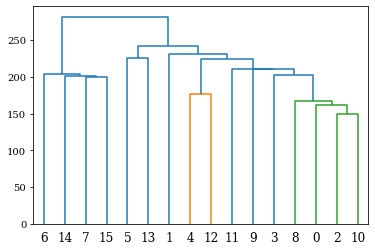

In [8]:
d=dendrogram(Z_genes)

# heat map

In [9]:
final_df=final_df.drop(['index'], axis=0)
final_df = final_df.astype(float)

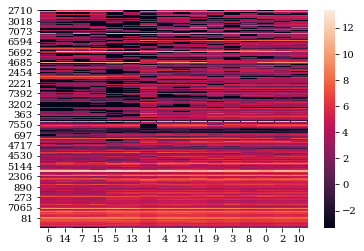

In [10]:
ax= sbn.heatmap(final_df)

# prepare data frame for part 2

In [11]:
df_transformed_indexed.insert(1, "stagenumber", "male_10", allow_duplicates=True)
df_transformed_indexed.insert(3, "stagenumber", "male_11", allow_duplicates=True)
df_transformed_indexed.insert(5, "stagenumber", "male_12", allow_duplicates=True)
df_transformed_indexed.insert(7, "stagenumber", "male_13", allow_duplicates=True)
df_transformed_indexed.insert(9, "stagenumber", "male_14", allow_duplicates=True)
df_transformed_indexed.insert(11, "stagenumber", "male_14", allow_duplicates=True)
df_transformed_indexed.insert(13, "stagenumber", "male_14", allow_duplicates=True)
df_transformed_indexed.insert(15, "stagenumber", "male_14", allow_duplicates=True)
df_transformed_indexed.insert(17, "stagenumber", "female_10", allow_duplicates=True)
df_transformed_indexed.insert(19, "stagenumber", "female_11", allow_duplicates=True)
df_transformed_indexed.insert(21, "stagenumber", "female_12", allow_duplicates=True)
df_transformed_indexed.insert(23, "stagenumber", "female_13", allow_duplicates=True)
df_transformed_indexed.insert(25, "stagenumber", "female_14", allow_duplicates=True)
df_transformed_indexed.insert(27, "stagenumber", "female_14", allow_duplicates=True)
df_transformed_indexed.insert(29, "stagenumber", "female_14", allow_duplicates=True)
df_transformed_indexed.insert(31, "stagenumber", "female_14", allow_duplicates=True)
df_transformed_indexed= df_transformed_indexed.rename(columns={"male_10": "FPKM", "male_11": "FPKM", "male_12": "FPKM", "male_13": "FPKM", "male_14A": "FPKM", "male_14B": "FPKM", "male_14C": "FPKM", "male_14D": "FPKM", "female_10": "FPKM", "female_11": "FPKM", "female_12": "FPKM", "female_13": "FPKM", "female_14A": "FPKM", "female_14B": "FPKM", "female_14C": "FPKM", "female_14D": "FPKM"})

In [12]:
df_male_10= df_transformed_indexed.iloc[:, :2]
df_male_11= df_transformed_indexed.iloc[:, 2:4]
df_male_12= df_transformed_indexed.iloc[:, 4:6]
df_male_13= df_transformed_indexed.iloc[:, 6:8]
df_male_14A= df_transformed_indexed.iloc[:, 8:10]
df_male_14B= df_transformed_indexed.iloc[:, 10:12]
df_male_14C= df_transformed_indexed.iloc[:, 12:14]
df_male_14D= df_transformed_indexed.iloc[:, 14:16]
df_female_10= df_transformed_indexed.iloc[:, 16:18]
df_female_11= df_transformed_indexed.iloc[:, 18:20]
df_female_12= df_transformed_indexed.iloc[:, 20:22]
df_female_13= df_transformed_indexed.iloc[:, 22:24]
df_female_14A= df_transformed_indexed.iloc[:, 24:26]
df_female_14B= df_transformed_indexed.iloc[:, 26:28]
df_female_14C= df_transformed_indexed.iloc[:, 28:30]
df_female_14D= df_transformed_indexed.iloc[:, 30:32]



df_concat=pd.concat([df_male_10,df_male_11, df_male_12, df_male_13, df_male_14A, df_male_14B, df_male_14C, df_male_14D, df_female_10, df_female_11, df_female_12, df_female_13, df_female_14A, df_female_14B, df_female_14C, df_female_14D], axis=0)
df_concat


df_concat['sex']=df_concat['stagenumber']
mapping = {'male_10': 10, 'male_11': 11, 'male_12': 12, 'male_13': 13, 'male_14': 14, 'male_14': 14, 'male_14': 14, 'male_14': 14, 'female_10': 10, 'female_11': 11, 'female_12': 12, 'female_13': 13, 'female_14': 14, 'female_14': 14, 'female_14': 14, 'female_14': 14}
mapping2 = {'male_10': 'male', 'male_11': 'male', 'male_12': 'male', 'male_13': 'male', 'male_14': 'male', 'male_14': 'male', 'male_14': 'male', 'male_14': 'male', 'female_10': 'female', 'female_11': 'female', 'female_12': 'female', 'female_13': 'female', 'female_14': 'female', 'female_14': 'female', 'female_14': 'female', 'female_14': 'female'}
mapping3={'male':0, 'female':1}
df_concat= df_concat.replace({'sex': mapping2, 'stagenumber': mapping})
df_concat=df_concat.replace({'sex':mapping3})
df_concat.reset_index(inplace=True)
df_concat


,gene_name,FPKM,stagenumber,sex
0,CR40182,4.573651,10,0
1,Parp,3.472120,10,0
2,Alg-2,4.260622,10,0
3,Tim17b,2.681610,10,0
4,Tim17b,6.899972,10,0
...,...,...,...,...
137803,mt:Cyt-b,7.386673,14,1
137804,mt:ND1,9.412730,14,1
137805,mt:lrRNA,12.153787,14,1
137806,CR41590,-2.713053,14,1


# part two- ordinary least squares analysis

In [13]:
df_pvals_no_sex=pd.DataFrame()
pvals=[]

genes=list(df_concat['gene_name'].unique())
for gene_name in genes: 
    data=df_concat[df_concat['gene_name'] == gene_name]
    gene_model= smf.ols(formula= 'stagenumber ~ 1 +FPKM', data=data)
    gene_fit=gene_model.fit()
    pval=gene_fit.pvalues
    pvals.append(pval['FPKM'])
df_pvals_no_sex['gene_name']= genes
df_pvals_no_sex['-log(p)']= -np.log(pvals)
df_pvals_no_sex

,gene_name,-log(p)
0,CR40182,0.306671
1,Parp,1.817829
2,Alg-2,1.335297
3,Tim17b,3.982842
4,CG41128,3.617683
...,...,...
5551,mt:Cyt-b,3.015564
5552,mt:ND1,2.972317
5553,mt:lrRNA,0.604029
5554,CR41590,1.767968


# QQ plot 

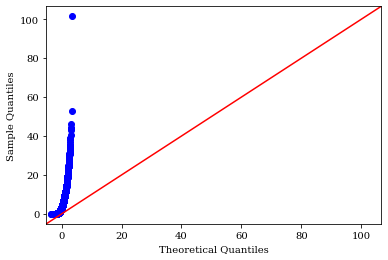

In [14]:
fig = sm.qqplot(df_pvals_no_sex['-log(p)'], line='45')
plt.show()

# false discovery rate without sex 

In [15]:
values_list1= list(df_pvals_no_sex['-log(p)'])
df_pvals_no_sex= df_pvals_no_sex.set_index('gene_name')
pvals_dict= df_pvals_no_sex.to_dict('dict')
print(pvals_dict.values())

dict_values([{'CR40182': 0.30667106990933235, 'Parp': 1.8178293038706512, 'Alg-2': 1.3352969393249075, 'Tim17b': 3.98284159887561, 'CG41128': 3.617683345501361, 'CG41099': 0.13217599661078192, 'CG12581': 9.378686946507225, 'CG12582': 4.601447268211273, 'aux': 0.05887768654456605, 'CG14641': 13.108631684161585, 'abs': 13.635801138707642, 'Vps24': 7.894598129856676, 'CG9795': 1.4582288036396358, 'CG9776': 4.137332650298403, 'Skp2': 3.390415784811537, 'CG1103': 0.8124388587295844, 'hkb': 21.184009911770726, 'CG11739': 8.624971451500866, 'CG14646': 1.8476005723507831, 'CG9855': 17.481578254935638, 'CG9853': 0.4474060721212134, 'CG14647': 6.1596463161547526, 'lost': 16.325828297545726, 'srl': 11.717368848907881, 'eIF3-S10': 1.0693547123645541, 'CG1074': 2.0606434950816293, 'CG9804': 3.3249528406938116, 'CR44134': 1.0811230751325427, 'CG14650': 0.9779053956801947, 'CG31523': 0.18700254971118196, 'CG14651': 3.4798631569582037, 'Fip1': 10.986569777240366, 'CG9775': 5.573681783957945, 'MED31': 

In [16]:
FDR=[]
FDR_no_sex_list=[]
counter=0

for i in values_list1: 
    if i > 1: 
        for value in pvals_dict.values():
            for key2, value2 in value.items():
                if i == value2:
                    FDR_no_sex_list.append(key2)
                    #counter += 1
                    #if counter > 1: 
                        #break 
                else: 
                    pass
    else: 
        pass
print(len(FDR_no_sex_list))

4284


# OLS analysis with sex as covariate 

In [17]:
df_pvals_with_sex=pd.DataFrame()
pvals_sex=[]

genes=list(df_concat['gene_name'].unique())
for gene_name in genes: 
    data=df_concat[df_concat['gene_name'] == gene_name]
    gene_model= smf.ols(formula= 'stagenumber ~ 1 +FPKM + sex', data=data)
    gene_fit=gene_model.fit()
    pval2=gene_fit.pvalues
    pvals_sex.append(pval2['FPKM'])
df_pvals_with_sex['gene_name']= genes
df_pvals_with_sex['-log(p)']= -np.log(pvals_sex)
df_pvals_with_sex

,gene_name,-log(p)
0,CR40182,0.293729
1,Parp,1.743043
2,Alg-2,1.294177
3,Tim17b,3.973230
4,CG41128,3.577853
...,...,...
5551,mt:Cyt-b,2.864834
5552,mt:ND1,2.860334
5553,mt:lrRNA,0.579101
5554,CR41590,1.726569


In [18]:
values_list2= list(df_pvals_with_sex['-log(p)'])
df_pvals_with_sex= df_pvals_with_sex.set_index('gene_name')
pvals_dict_with_sex= df_pvals_with_sex.to_dict('dict')
#print(pvals_dict_with_sex.values())

In [19]:
FDR_sex=[]
FDR_with_sex_list=[]
counter=0
counter2=0
counter3=0

for i in values_list2: 
    if i > 1: 
        for value in pvals_dict_with_sex.values():
            for key2, value2 in value.items():
                if i == value2:
                    FDR_with_sex_list.append(key2)
                    #counter += 1
                    #if counter > 1: 
                        #break 
                else: 
                    pass
                    #counter2 += 1
                   # if counter2 > 1: 
                        #break 
    else: 
        pass
print(len(FDR_with_sex_list))

4264


In [20]:
with open("no_sex_differentially_expressed_genes", "w") as outfile:
    outfile.write("\n".join(FDR_no_sex_list))
    
with open("with_sex_differentially_expressed_genes", "w") as outfile:
    outfile.write("\n".join(FDR_with_sex_list))

# percentage overlap between lists

In [21]:
# ((# overlapping genes) / (# genes in list without covariate)) * 100
overlapping=len(FDR_no_sex_list)-(len(FDR_no_sex_list)-len(FDR_with_sex_list))
percent_overlap= (overlapping/(len(FDR_no_sex_list))) *100
print(percent_overlap)

99.53314659197012


# volcano plot

In [22]:
from bioinfokit import analys, visuz

In [23]:
visuz.volcano(df_pvals_with_sex, lfc='-log(p)', pv='-log(p)')

ValueError: Invalid file path or buffer object type: <class 'pandas.core.frame.DataFrame'>